<a href="https://colab.research.google.com/github/chdhatri/Anamoly-Detection/blob/main/Tip_Script.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!mkdir videos
!cp -r /content/drive/MyDrive/weights /content
!cp /content/drive/MyDrive/train.mp4  /content/videos
!cp /content/drive/MyDrive/test.mp4 /content/videos


cp: cannot stat '/content/drive/MyDrive/9-part1.mkv': No such file or directory


In [21]:
!cp /content/drive/MyDrive/Tip_too_low_part1.mp4 /content/videos

In [3]:
!pip install ultralytics
!pip install supervision
!pip install scikit-learn
!pip install lap
!pip install tools
!pip install opencv-python
!pip install pytesseract

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.3/612.3 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.3/59.3 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 9.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lap: filename=lap-0.4.0-cp310-cp310-linux_x86_64.whl size=1628962 sha256=430497d1fbc4c65fae352c860ba51a8bab666317ad84215184069b31e053387a
  Stored in directory: /root/.cache/pip/wheels/00/42/2e/9dfe19270eea279d79e84767ff0d7b8082c3bf776cad00e83d
Successfully built lap
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 4.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for tools: filename=tools-0.1.9-py3-none-any.whl size=46731 sha256=a99da2ab205c14cd4b371ae28432d2e8fbabb6b6ec4f1923fa581eac7504220d
  Stored in directory: /root

In [4]:
!mkdir -p /content/weights
!wget -P /content/weights -q https://huggingface.co/spaces/An-619/FastSAM/resolve/main/weights/FastSAM.pt
!wget -P /content/weights -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
!ls -lh /content/weights

total 2.6G
-rw------- 1 root root  22M Aug 30 14:18 best.pt
drwx------ 2 root root 4.0K Aug 30 14:18 cylinder_weights
-rw-r--r-- 1 root root 139M Jun 20 07:01 FastSAM.pt
-rw------- 1 root root  22M Aug 30 14:18 last.pt
-rw-r--r-- 1 root root 2.4G Apr  4 06:56 sam_vit_h_4b8939.pth


In [5]:
# install FastSAM
!git clone https://github.com/CASIA-IVA-Lab/FastSAM.git
!pip -q install -r FastSAM/requirements.txt
# install CLIP
!pip -q install git+https://github.com/openai/CLIP.git
# install SAM
!pip -q install git+https://github.com/facebookresearch/segment-anything.git
# install other dependencies
!pip -q install roboflow supervision jupyter_bbox_widget

Cloning into 'FastSAM'...
remote: Enumerating objects: 688, done.
remote: Counting objects: 100% (162/162), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 688 (delta 121), reused 120 (delta 112), pack-reused 526
Receiving objects: 100% (688/688), 65.99 MiB | 41.48 MiB/s, done.
Resolving deltas: 100% (395/395), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.7/19.7 MB 76.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.7/611.7 kB 55.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.2/66.2 kB 8.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.2/298.2 kB 33.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9

In [6]:
!cp -r /content/drive/MyDrive/cylinder_weights /content/weights
!mkdir "/content/train_images"
!mkdir "/content/train_masks"


cp: cannot stat '/content/drive/MyDrive/cylinder_weights': No such file or directory


In [15]:
import ultralytics
from ultralytics import YOLO
import cv2
import numpy as np
import os
import pandas as pd
from IPython.display import display, Image
from tqdm import tqdm
from skimage import io, color, measure, filters
import matplotlib.pyplot as plt
import time
ultralytics.checks()

import torch
import roboflow
import base64

import supervision as sv

from roboflow import Roboflow
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor




def get_mask_height(mask):

   # Find the active coordinates
    coords = np.column_stack(np.where(mask))

    # Extract bounding box coordinates
    y_min, x_min = coords.min(axis=0)
    y_max, x_max = coords.max(axis=0)

    # Calculate the height in pixels
    height_in_pixels = y_max - y_min + 1  # "+ 1" to include both boundary pixels

    # Assume pixel spacing (resolution) is given, for example:
    pixel_spacing = 0.0104  # 1/96 dpi mm/pixel

    # Convert height in pixels to height in mm
    height_in_mm = height_in_pixels * pixel_spacing

    return height_in_mm


def get_region_height(mask):
  gray = color.rgb2gray(mask)

  # Threshold the image to create a binary mask (assuming mask is brighter than the background)
  binary = gray > filters.threshold_otsu(gray)

  # Label the regions in the binary mask
  label_image = measure.label(binary)

  # Measure properties of labeled regions
  properties = measure.regionprops(label_image)

  # Assuming the mask is a single region; if not, you'd iterate through regions
  region = properties[0]

  # Height of the mask
  height = region.bbox[2] - region.bbox[0]

  # Area of the mask
  area = region.area

  return area, height


def feret_diameter(region):
    """Compute the maximum Feret diameter for a region."""
    max_diameter = 0
    coords = region.coords

    for i in range(len(coords)):
        for j in range(i+1, len(coords)):
            distance = np.linalg.norm(coords[i] - coords[j])
            if distance > max_diameter:
                max_diameter = distance

    return max_diameter

def annotate_image(image_path: str, masks: np.ndarray) -> np.ndarray:
    image = cv2.imread(image_path)

    xyxy = sv.mask_to_xyxy(masks=masks)
    detections = sv.Detections(xyxy=xyxy, mask=masks)

    mask_annotator = sv.MaskAnnotator()
    return mask_annotator.annotate(scene=image.copy(), detections=detections)

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def return_mask(mask,random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    return mask_image

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

def save_mask_on_image(original, mask, output_file, text, out,random_color=False):

    color = np.array([0/255, 0/255, 128/255, 0.6])

    # Convert 3-channel mask to single channel
    # Here we're using the blue channel, but you can change this if needed
     # Check if mask has 3 channels
    if len(mask.shape) == 3 and mask.shape[2] == 3:
        mask_single_channel = mask[:, :, 0]
    else:
        mask_single_channel = mask


    h, w = mask_single_channel.shape
    mask_colored = (mask_single_channel.reshape(h, w, 1) * color[:3].reshape(1, 1, -1)).astype(np.float32)
    # Find the active coordinates
    coords = np.column_stack(np.where(mask))

    # Extract bounding box coordinates
    y_min, x_min = coords.min(axis=0)
    y_max, x_max = coords.max(axis=0)
    # Ensure original image is in float32 and range [0, 1]
    original_float = original.astype(np.float32) / 255.0

    # Combine original image with the colored mask
    combined = cv2.addWeighted(original_float, 1, mask_colored, color[3], 0)

    # Convert combined image back to range [0, 255] for saving
    combined = (combined * 255).astype(np.uint8)



    # Annotate the image with height information
    font = cv2.FONT_HERSHEY_SIMPLEX
    position = (10, 50)  # You can change this to the desired position on the image
    font_scale = 2
    font_color = (0, 0, 0)  # Blue color
    font_thickness = 6

    #cv2.rectangle(combined, (x_min, y_min), (x_max,y_max), (0,255,0), 1)
    cv2.putText(combined, text, position, font, font_scale, font_color, font_thickness)

    mask_image = return_mask(mask,random_color=False)

    #out.write(combined)
    # Save the combined image
    cv2.imwrite(output_file, combined)


################old logic ####################################
#######################################################
#####################################
def extract_frames(video_path, output_folder):
  cap = cv2.VideoCapture(video_path)
  # Define the codec and create VideoWriter object
  fourcc = cv2.VideoWriter_fourcc(*'XVID')
  out = cv2.VideoWriter('all_frames_output.avi', fourcc, 20.0, (int(cap.get(3)), int(cap.get(4))))

  data = []
  if not cap.isOpened():
    print("Error opening video file")
    return

  fps = cap.get(cv2.CAP_PROP_FPS)
  frames_per_output = fps // 2
  frame_count = 0#start_frame
  total_time = 0
  output_count = 0
  iter = 1
  new_iter = 1
  with tqdm(total=int(cap.get(cv2.CAP_PROP_FRAME_COUNT))) as pbar:
    while True:
      ret, frame = cap.read()

      if not ret:
        break

      # Define the codec and create VideoWriter object
      fourcc = cv2.VideoWriter_fourcc(*'XVID')
      out = cv2.VideoWriter('output_full.avi', fourcc, 20.0, (int(cap.get(3)), int(cap.get(4))))


      # Determine the current second in the video
      current_second = frame_count // fps

      if frame_count % frames_per_output  == 0:
        # Compute the index of the frame within the current second (0, 1, or 2)
        frame_within_second = (frame_count % fps) // (fps // 2)
        #frame label correspnds to the fps count
        frame_label = int(frame_count/fps) + 1
        #check for the rotation number
        if frame_label % 8 == 0:
            new_iter = int(frame_label/8) + 1

        file_name = f"frame_{frame_label}S_{int(frame_within_second)}F_{new_iter}I.jpg"
        output_path = f"{output_folder}/{file_name}"
        mask_path = f"{mask_folder}/{file_name}"

        #processing start time
        start_time = time.time()
        predictor.set_image(frame)

        #predict the SAM
        masks, scores, logits = predictor.predict(
          point_coords=input_point,
          point_labels=input_label,
          multimask_output=True,
          )

      for i, (mask, score) in enumerate(zip(masks, scores)):
        area = np.sum(mask.astype(bool))

        #if area < 2000:
          # Convert to numpy array for easier processing
        mask_array = np.array(mask)

          # Check rows where the mask is present
        rows_with_mask = np.any(mask_array > 0, axis=1)  # This considers any non-zero value as mask. Adjust the threshold as required.

          # Find the first and last row containing the mask
        first_row = np.where(rows_with_mask)[0][0]
        last_row = np.where(rows_with_mask)[0][-1]

          # Calculate the height
        height = (last_row - first_row + 1) * (1/96)
        text = f"Ht: {height:.2f}mm Area: {area}"
          #print("Start writting frames" )
        save_mask_on_image(frame, mask, output_path, text,out)
          #print("Frame written to:",{file_name})
        data.append([file_name, area, height])

      # Convert data to a DataFrame and then to a CSV file
      csv_file = '/content/data.csv'
      df = pd.DataFrame(data, columns=['Frame Number', 'Area', 'Height (mm)'])
      df.to_csv(csv_file, index=False)

      end_time = time.time()
      total_time += end_time - start_time

      frame_count += 1
      pbar.update(1)
      out.write(frame)
      # If frame_count is multiple of 100, print the average time
      if frame_count % 100 == 0:
        average_time = total_time / 100
        print(f"Average time for last 100 frames: {average_time:.4f} seconds")
        total_time = 0  # Reset total time for next batch of frames

  cap.release()



Ultralytics YOLOv8.0.120 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 29.7/166.8 GB disk)


In [8]:
!cp /content/drive/MyDrive/Tip_right_height_part1.mp4 /content/videos

In [19]:
####################################################################
##################### Refactored logic ################################
###################################################################
import pandas as pd
import numpy as np
from tqdm import tqdm
import cv2
import time
import matplotlib.pyplot as plt

# Annotate the image with height information
font = cv2.FONT_HERSHEY_SIMPLEX
position = (10, 50)  # You can change this to the desired position on the image
font_scale = 2
font_color = (0, 30, 255)  # Blue color
font_thickness = 4

########## find red square bounding box in the frame ###################
def find_red_square(frame):
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    lower_red = np.array([0, 0, 200])
    upper_red = np.array([100, 100, 255])

    red_mask = cv2.inRange(frame, lower_red, upper_red)
    contours, _ = cv2.findContours(red_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    bbox = None
    for contour in contours:
        if cv2.contourArea(contour) > 500:  # filter out small contours
            x, y, w, h = cv2.boundingRect(contour)
            bbox = x, y, w, h
            cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)

    return bbox


#### from the red box bbox check if the box has green color##################
def is_green_square(frame, bbox):
    x, y, w, h = bbox

    roi = frame[y:y+h, x:x+w]

    # Define lower and upper range for green color in BGR format
    lower_green = np.array([0, 100, 0])
    upper_green = np.array([50, 255, 50])

    mask_green = cv2.inRange(roi, lower_green, upper_green)
    return np.any(mask_green)


####### Overlay the mask on the frames #################
def save_mask_on_image(original, mask, output_file, text,out, random_color=False):

    color = np.array([0/255, 0/255, 128/255, 0.6])

    # Convert 3-channel mask to single channel
    # Check if mask has 3 channels
    if len(mask.shape) == 3 and mask.shape[2] == 3:
        mask_single_channel = mask[:, :, 0]
    else:
        mask_single_channel = mask


    h, w = mask_single_channel.shape
    mask_colored = (mask_single_channel.reshape(h, w, 1) * color[:3].reshape(1, 1, -1)).astype(np.float32)
    # Find the active coordinates
    coords = np.column_stack(np.where(mask))

    # Extract bounding box coordinates for the mask
    y_min, x_min = coords.min(axis=0)
    y_max, x_max = coords.max(axis=0)
    # Ensure original image is in float32 and range [0, 1]
    original_float = original.astype(np.float32) / 255.0

    # Combine original image with the colored mask
    combined = cv2.addWeighted(original_float, 1, mask_colored, color[3], 0)

    # Convert combined image back to range [0, 255] for saving
    combined = (combined * 255).astype(np.uint8)


    cv2.rectangle(combined, (x_min, y_min), (x_max,y_max), (0,255,0), 1)
    cv2.putText(combined, text, position, font, font_scale, font_color, font_thickness)

    #mask_image = return_mask(mask,random_color=False)

    #out.write(combined)
    # Save the combined image
    cv2.imwrite(output_file, combined)
    return combined

"""Determine if the current frame has green box and should be processed."""
def should_process_frame(frame, bbox):
  if bbox is not None:
    return is_green_square(frame, bbox)
  else:
    print("No red box found on frame")

"""Process a single frame and return relevant data."""
def process_frame(frame, output_folder, frame_count, green_count, fps, out):
    data = []
    overlay_img = frame
    text = ""

    #  logic to determine the current second, filename, etc.
    current_second = frame_count // fps
    frame_within_second = (frame_count % fps) // (fps // 2)
    frame_label = int(frame_count/fps) + 1
    new_iter = int(frame_label/8) + 1 if frame_label % 8 == 0 else 1
    file_name = f"frame_{frame_label}S_green_{int(green_count)}F.jpg"

    #  predictor logic here
    predictor.set_image(frame)
    masks, scores, logits = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        multimask_output=True,
    )

    for i, (mask, score) in enumerate(zip(masks, scores)):
        area = np.sum(mask.astype(bool))
        print("Area:", area)

        # Further processing logic
        if area < 4000:
            mask_array = np.array(mask)
            rows_with_mask = np.any(mask_array > 0, axis=1)
            first_row = np.where(rows_with_mask)[0][0]
            last_row = np.where(rows_with_mask)[0][-1]
            height = (last_row - first_row + 1) * (1/96)
            text = f"Ht: {height:.2f}mm Area: {area}"
            print("Process Text:", text)
            overlay_img = save_mask_on_image(frame, mask, os.path.join(output_folder, file_name), text, out)

            data.append([file_name, area, height])

    return data, overlay_img, text

def extract_image_frames(video_path, output_folder, csv_file):
    cap = cv2.VideoCapture(video_path)
    all_data = []
    total_time = 0
    prev_green_txt = ""

    if not cap.isOpened():
        print("Error opening video file")
        return

    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter('output_full.avi', fourcc, 20.0, (int(cap.get(3)), int(cap.get(4))))

    fps = int(cap.get(cv2.CAP_PROP_FPS))
    red_bbox = None
    is_frame_green = False
    green_counter = 1
    processed_frame = None
    with tqdm(total=int(cap.get(cv2.CAP_PROP_FRAME_COUNT))) as pbar:
        frame_count = 0
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            start_time = time.time()
            if red_bbox is None:
              red_bbox = find_red_square(frame)

            '''Process the frames for the green box '''
            if should_process_frame(frame, red_bbox):

                is_frame_green = True

                frame_data, overly_frame, text = process_frame(frame, output_folder, frame_count, green_counter, fps, out)

                processed_frame = overly_frame
                prev_green_txt = text
                print("Processing green frame:", prev_green_txt)
                green_counter += 1
                all_data.extend(frame_data)
            else:
                processed_frame = frame
                is_frame_green = False
                print("Processing red frame:", prev_green_txt)
                if not is_frame_green:
                  cv2.putText(frame, prev_green_txt, position, font, font_scale, font_color, font_thickness)


            # Write the output frame to video
            out.write(processed_frame)
            end_time = time.time()
            total_time += end_time - start_time
            frame_count += 1
            pbar.update(1)

            # If frame_count is multiple of 100, print the average time
            if frame_count % 100 == 0:
              average_time = total_time / 100
              print(f"Average time for last 100 frames: {average_time:.4f} seconds")
              total_time = 0  # Reset total time for next batch of frames


    # Convert data to a DataFrame and then to a CSV file
    df = pd.DataFrame(all_data, columns=['Frame Number', 'Area', 'Height (mm)'])
    df.to_csv(csv_file, index=False)

    cap.release()
    out.release()



In [23]:
!rm -rf /content/train_images/
!mkdir  /content/train_images/


In [10]:
import torch
import numpy as np
import pickle
import os
import sys
''' load the SAM model and Predictor '''

SAM_SAM_CHECKPOINT_PATH = "/content/weights/sam_vit_h_4b8939.pth"

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

sam = sam_model_registry[MODEL_TYPE](checkpoint=SAM_SAM_CHECKPOINT_PATH).to(device=DEVICE)



In [ ]:
import datetime
import time
if __name__ == "__main__":
    predictor = SamPredictor(sam)

    #Reference input point
    input_point = np.array([[1000, 675]])
    input_label = np.array([1])

    video_path = "/content/videos/Tip_too_low_part1.mp4"
    output_folder = "/content/train_images"
    mask_folder = "/content/train_masks"
    csv_file = '/content/data.csv'
    # Capture the start time
    start_time = datetime.datetime.now()
    extract_image_frames(video_path, output_folder, csv_file)
    #extract_frames(video_path, output_folder)
    end_time = datetime.datetime.now()

    elapsed_time = end_time - start_time
    print(f"Elapsed time: {elapsed_time}")



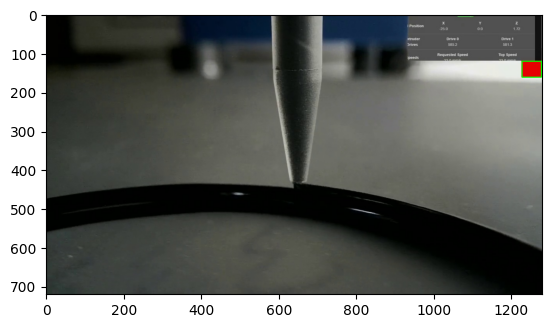

In [118]:
img = cv2.imread('/content/train_images/frame_38.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


frame, bbox = find_red_square(img)

frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
plt.imshow(frame)
plt.show()

In [100]:
def extract_frames_with_green_box(video_path):
    cap = cv2.VideoCapture(video_path)

    frame_count = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break


            # Process or save the frame with the green box
        file_name = f"frame_{frame_count}.jpg"
        cv2.imwrite(os.path.join(output_folder, file_name), frame)

        frame_count += 1

    cap.release()

# Call the function
video_path = "/content/videos/Tip_right_height_part1.mp4"
output_folder = "/content/train_images"
extract_frames_with_green_box(video_path)



KeyboardInterrupt: ignored

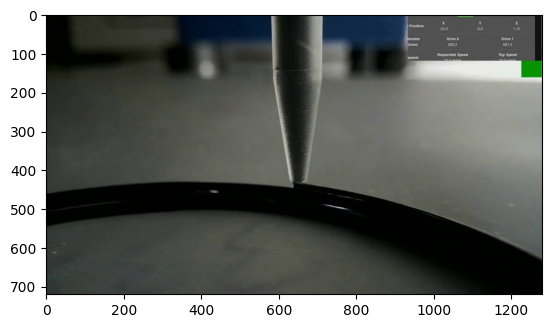

In [101]:
img = cv2.imread('/content/train_images/frame_36.jpg')

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()


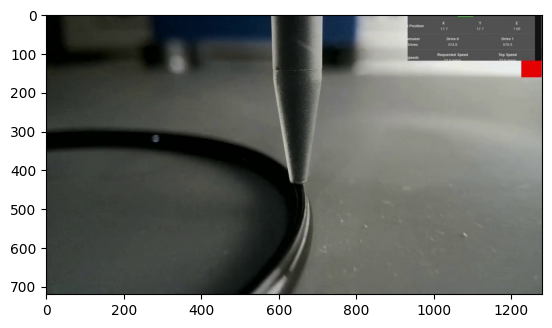

In [86]:
img = cv2.imread('/content/train_images/frame_0.jpg',1)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()


In [122]:
!rm -rf /content/train_images/
!mkdir  /content/train_images/


In [ ]:
!cp /content/output_nobox1.avi /content/drive/MyDrive

In [ ]:
!pip install opencv-python pytesseract

In [ ]:
!apt install tesseract-ocr

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 16 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 0s (12.3 MB/s)
Selecting previously unselected package tesseract-ocr-eng.
(Reading database ... 120831 files and directories currently installed.)
Preparing to unpack .../tesseract-ocr-e

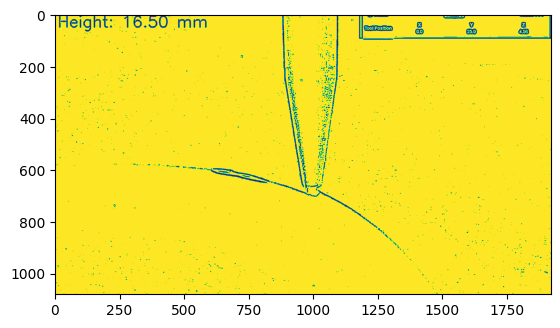

i aad ey , my os
a a — -
4 D ee.
p eee:
Pee =u re ie
: <<.) ] q ees ae
ee eves: ,
‘aes pearl’ ~ 7 : F : f
ales ii
amen a? oe”
7 2
ies .
eee
nd on. *
ete Be
: cea
— f
ae .
i. +
. aa .
See rn So
See Bs > ae
me aS ag, ae
mei Sogn
a ee. ons Ta 7 ¥
Famers a
Sg ee, Eee sek”



In [ ]:
import cv2
import pytesseract
import matplotlib.pyplot as plt

# Use pytesseract to extract text from the frame
frame = cv2.imread("/content/train_masks/frame_125S_4F_16I.jpg")
# Convert to grayscale
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
gauss = cv2.GaussianBlur(gray, (5, 5), 0)

# Apply adaptive thresholding

# Resize the frame to enlarge the text (optional, you can experiment with the factor)
#gray = cv2.resize(gray, None, fx=1.5, fy=1.5, interpolation=cv2.INTER_LINEAR)

# Apply adaptive thresholding
binary = cv2.adaptiveThreshold(gauss, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

plt.imshow(binary)
plt.show()

# Perform OCR
text = pytesseract.image_to_string(gray, config='--psm 6')
print(text)

